In [21]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# На всякий случай фикс для NumPy>=2 и старого gym
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

/var/folders/w2/lbvmkxld183gw6xrd3y32vp00000gn/T/ipykernel_17174/2925633480.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, "bool8"):


In [22]:
env = gym.make("CartPole-v1")
n_actions = env.action_space.n  # 2 действия

In [23]:
# (позиция тележки, скорость тележки, угол шеста, угловая скорость шеста)
n_bins = (3, 3, 12, 12)

obs_high = env.observation_space.high
obs_low = env.observation_space.low

# Ограничиваем скорости (эвристика)
obs_low[1], obs_high[1] = -2.0, 2.0   # скорость тележки
obs_low[3], obs_high[3] = -3.0, 3.0   # угловая скорость шеста

# Границы бинов для каждого признака
bins = [
    np.linspace(obs_low[i], obs_high[i], n_bins[i] - 1)
    for i in range(len(n_bins))
]

def discretize(obs):
    """Непрерывное состояние -> дискретный индекс (кортеж)."""
    return tuple(
        int(np.digitize(obs[i], bins[i]))
        for i in range(len(n_bins))
    )

In [24]:
q_table = np.zeros(n_bins + (n_actions,))

In [25]:
gamma = 0.99

# alpha с затуханием
alpha_start = 0.2
alpha_min = 0.05
alpha_decay = 0.999

# epsilon-жадная стратегия
epsilon_start = 1.0
epsilon_min = 0.001
epsilon_decay = 0.997
decay_stop_episode = 3000

n_episodes = 5000
max_steps = 500

def choose_action(state, epsilon):
    """ε-жадный выбор действия."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return int(np.argmax(q_table[state]))

In [26]:
reward_history = []

alpha = alpha_start
epsilon = epsilon_start

for episode in range(n_episodes):
    obs, info = env.reset()
    state = discretize(obs)
    total_reward = 0

    for t in range(max_steps):
        # 1. выбор действия
        action = choose_action(state, epsilon)

        # 2. шаг среды
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        next_state = discretize(next_obs)

        # 3. обновление Q-функции (Q-learning)
        best_next_q = np.max(q_table[next_state])
        td_target = reward + gamma * best_next_q * (not done)
        td_error = td_target - q_table[state + (action,)]
        q_table[state + (action,)] += alpha * td_error

        state = next_state
        total_reward += reward

        if done:
            break

    reward_history.append(total_reward)

    # обновление epsilon
    if episode < decay_stop_episode:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
    else:
        epsilon = epsilon_min

    # обновление alpha
    alpha = max(alpha_min, alpha * alpha_decay)

    if (episode + 1) % 500 == 0:
        print(
            f"Эпизод {episode + 1}/{n_episodes} | "
            f"награда: {total_reward:.0f} | "
            f"epsilon: {epsilon:.4f} | alpha: {alpha:.4f}"
        )

env.close()

Эпизод 500/5000 | награда: 194 | epsilon: 0.2226 | alpha: 0.1213
Эпизод 1000/5000 | награда: 87 | epsilon: 0.0496 | alpha: 0.0735
Эпизод 1500/5000 | награда: 500 | epsilon: 0.0110 | alpha: 0.0500
Эпизод 2000/5000 | награда: 21 | epsilon: 0.0025 | alpha: 0.0500
Эпизод 2500/5000 | награда: 500 | epsilon: 0.0010 | alpha: 0.0500
Эпизод 3000/5000 | награда: 500 | epsilon: 0.0010 | alpha: 0.0500
Эпизод 3500/5000 | награда: 500 | epsilon: 0.0010 | alpha: 0.0500
Эпизод 4000/5000 | награда: 500 | epsilon: 0.0010 | alpha: 0.0500
Эпизод 4500/5000 | награда: 500 | epsilon: 0.0010 | alpha: 0.0500
Эпизод 5000/5000 | награда: 500 | epsilon: 0.0010 | alpha: 0.0500


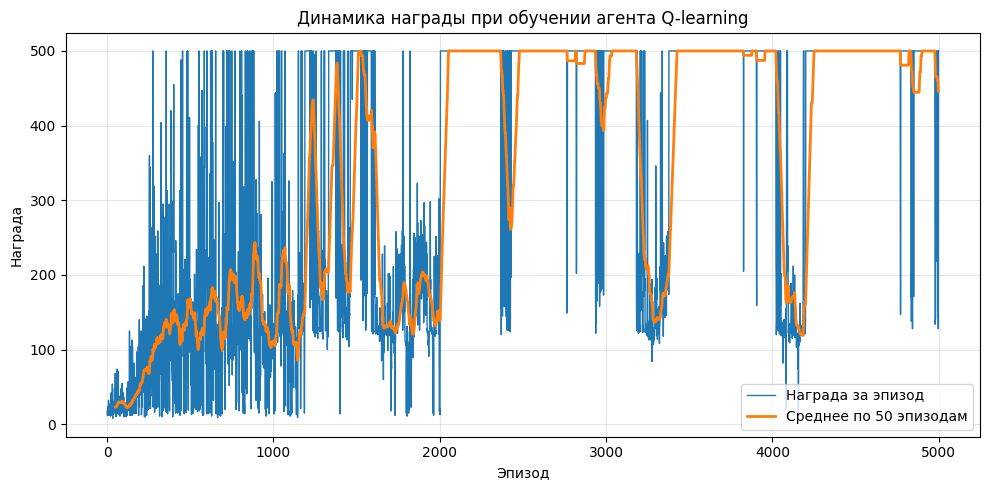

In [27]:
window = 50
rewards = np.array(reward_history)

if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window) / window, mode="valid")
else:
    moving_avg = rewards

plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Награда за эпизод", linewidth=1)
if len(rewards) >= window:
    plt.plot(
        range(window - 1, window - 1 + len(moving_avg)),
        moving_avg,
        label=f"Среднее по {window} эпизодам",
        linewidth=2,
    )
plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.title("Динамика награды при обучении агента Q-learning")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
def evaluate_agent(env, episodes=20, max_steps=500):
    """Запуск агента без ε-жадности, только эксплуатация."""
    total_rewards = []

    for ep in range(episodes):
        obs, info = env.reset()
        state = discretize(obs)
        ep_reward = 0

        for t in range(max_steps):
            action = int(np.argmax(q_table[state]))  # без случайности
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            state = discretize(obs)
            ep_reward += reward

            if done:
                break

        total_rewards.append(ep_reward)

    total_rewards = np.array(total_rewards)
    print(
        f"Оценка: средняя награда = {total_rewards.mean():.1f} "
        f"± {total_rewards.std():.1f} по {episodes} эпизодам"
    )
    return total_rewards

env = gym.make("CartPole-v1")
eval_rewards = evaluate_agent(env, episodes=20, max_steps=500)
env.close()

Оценка: средняя награда = 177.0 ± 23.7 по 20 эпизодам


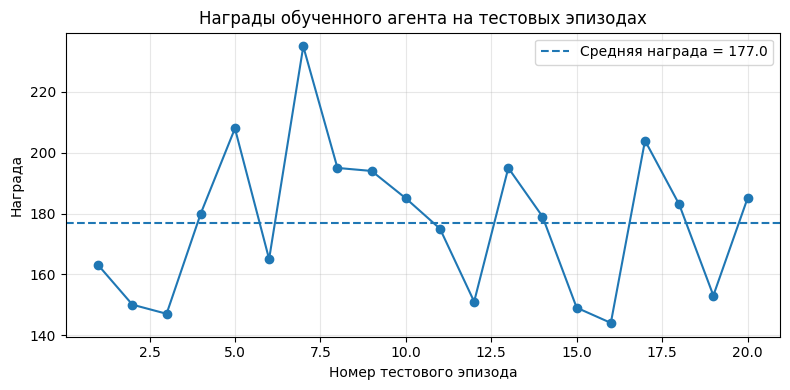

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(eval_rewards) + 1), eval_rewards, marker="o")
plt.axhline(eval_rewards.mean(), linestyle="--", linewidth=1.5,
            label=f"Средняя награда = {eval_rewards.mean():.1f}")
plt.xlabel("Номер тестового эпизода")
plt.ylabel("Награда")
plt.title("Награды обученного агента на тестовых эпизодах")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()